In [151]:
#imports
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [437]:
#open files
df = pd.read_csv('Tracks.csv')
feat_df=pd.read_csv('Music Features.csv')

In [438]:
df[df['Track Popularity']==81]

,Unnamed: 0,Tracks,Track Name,Artist,Artist Name,Artist Popularity,Artist Genre,Album,Track Popularity,Release Dates,...,key,loudness,mode,speechiness,acousticness,instrumentalness,instrumentalness.1,liveness,valence,tempo
114,114,spotify:track:2KnLkZ3z7PO3kgVGHGqDpD,It'll Be Okay,{'external_urls': {'spotify': 'https://open.sp...,Shawn Mendes,84,"['canadian pop', 'pop', 'viral pop']",It'll Be Okay,81,2021-12-01,...,7.0,-11.881,1.0,0.033,0.616,0.000146,0.000146,0.0912,0.0666,78.262


In [439]:
data=pd.concat([df['Track Popularity'],df['Release Dates'],df['Artist Popularity'],feat_df], axis=1)

In [440]:
data=data.dropna()

In [441]:
data=data.drop('Unnamed: 0',axis=1)

Text(0.5, 1.0, 'Popularity Distribution')

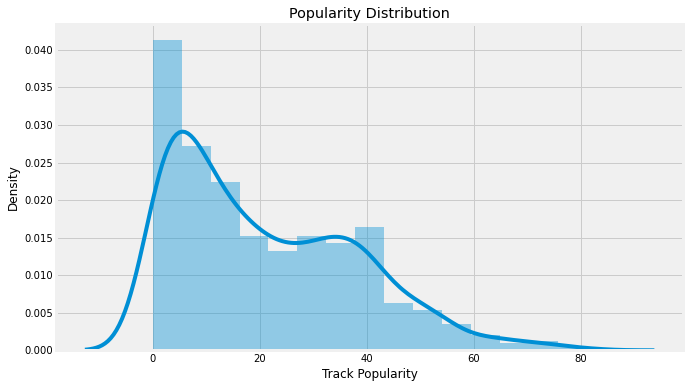

In [444]:
plt.figure(figsize=(10,6))
sns.distplot(data['Track Popularity']).set_title('Popularity Distribution')


Extracting year from 'Release Dates' feature

In [10]:
data['date']=pd.to_datetime(data['Release Dates'])

In [11]:
data['year']=data['date'].dt.year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, '1972'),
  Text(1, 0, '1984'),
  Text(2, 0, '1987'),
  Text(3, 0, '1992'),
  Text(4, 0, '1993'),
  Text(5, 0, '1994'),
  Text(6, 0, '1999'),
  Text(7, 0, '2000'),
  Text(8, 0, '2003'),
  Text(9, 0, '2004'),
  Text(10, 0, '2005'),
  Text(11, 0, '2006'),
  Text(12, 0, '2009'),
  Text(13, 0, '2010'),
  Text(14, 0, '2011'),
  Text(15, 0, '2012'),
  Text(16, 0, '2013'),
  Text(17, 0, '2014'),
  Text(18, 0, '2015'),
  Text(19, 0, '2016'),
  Text(20, 0, '2017'),
  Text(21, 0, '2018'),
  Text(22, 0, '2019'),
  Text(23, 0, '2020'),
  Text(24, 0, '2021'),
  Text(25, 0, '2022')])

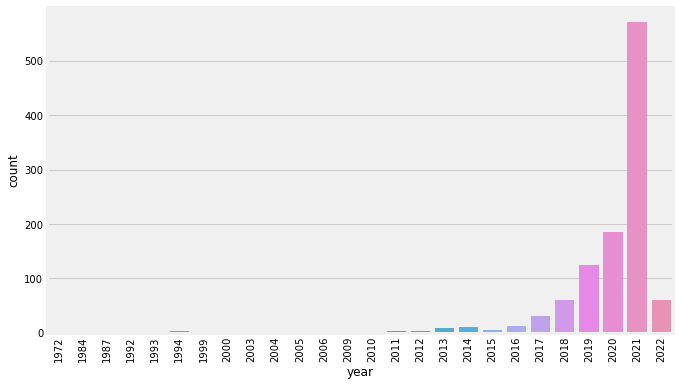

In [12]:
#plot a countplot of 
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='year')
plt.xticks(rotation='vertical')


In [13]:
data=data.drop('instrumentalness.1',axis=1)

<AxesSubplot:xlabel='key', ylabel='count'>

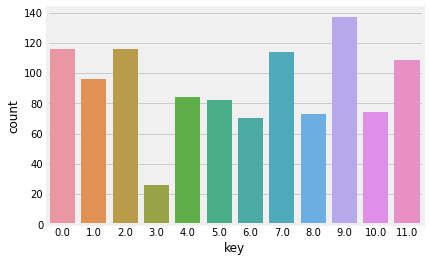

In [14]:
sns.countplot(data=data, x='key')

In [15]:
data[data['year']<2018]['Track Popularity'].mean()

24.90625

In [16]:
data[data['year']>=2018]['Track Popularity'].mean()

20.73126873126873

<AxesSubplot:xlabel='year', ylabel='Track Popularity'>

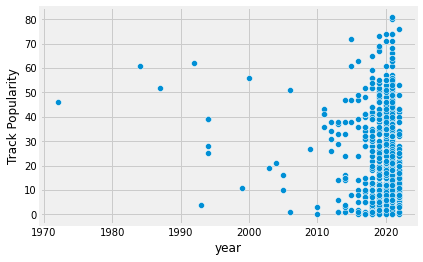

In [74]:
sns.scatterplot(x='year',y='Track Popularity',data=data)

<AxesSubplot:xlabel='danceability', ylabel='liveness'>

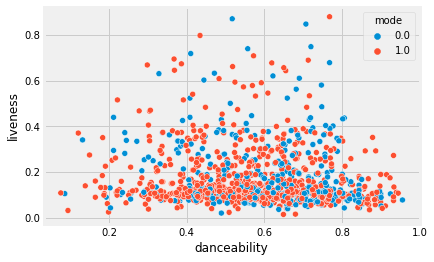

In [17]:
sns.scatterplot(x='danceability',y='liveness',hue='mode',data=data)

In [18]:
data[data['year']>=2019]['Track Popularity'].count()

941

In [19]:
data[data['year']>=2019]['Track Popularity'].mean()

20.59192348565356

In [20]:
#create dummies
df_keys=pd.get_dummies(data.key,drop_first=True)


In [331]:
df_keys=df_keys.rename(columns={1.0:'key 1',2.0:'key 2',3.0:'key 3',4.0:'key 4',
                                5.0:'key 5',6.0:'key 6',7.0:'key 7',8.0:'key 8',
                               9.0:'key 9',10.0:'key 10',11.0:'key 11'})

In [332]:
df_keys

,key 1,key 2,key 3,key 4,key 5,key 6,key 7,key 8,key 9,key 10,key 11
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1093,0,0,0,0,0,0,0,1,0,0,0
1094,1,0,0,0,0,0,0,0,0,0,0
1095,0,0,0,0,0,0,1,0,0,0,0
1096,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df_mode=pd.get_dummies(data['mode'],drop_first=True)

In [22]:
df_mode=df_mode.rename(columns={1.0:'mode 1'})

In [333]:
df0=pd.concat([data,df_keys,df_mode],axis=1)

In [334]:
df0=df0.drop(['mode','key'],axis=1)

Index(['Track Popularity', 'Release Dates', 'Artist Popularity',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'date', 'year',
       'key 1', 'key 2', 'key 3', 'key 4', 'key 5', 'key 6', 'key 7', 'key 8',
       'key 9', 'key 10', 'key 11', 'mode 1'],
      dtype='object')

In [336]:
#drop old songs. Let's assume that old is a song released before 2019
df1=df0[df0['year']>=2019]

In [337]:
#generate descriptive statistics for track popularity
df1.describe(percentiles=[.05,.10,.15,.20,.25,.5,.75,.8,.85,.9,.95])

,Track Popularity,Artist Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,key 3,key 4,key 5,key 6,key 7,key 8,key 9,key 10,key 11,mode 1
count,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,...,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000
mean,20.591923,22.615303,0.581325,0.637572,-7.983520,0.090465,0.233501,0.130395,0.177014,0.489557,...,0.026567,0.072264,0.079702,0.063762,0.099894,0.063762,0.123273,0.070138,0.103082,0.640808
std,16.839395,16.503344,0.166510,0.204366,3.243433,0.100420,0.276719,0.259154,0.133734,0.236457,...,0.160901,0.259061,0.270976,0.244458,0.300018,0.244458,0.328925,0.255516,0.304227,0.480019
min,0.000000,0.000000,0.074900,0.037600,-34.628000,0.023900,0.000003,0.000000,0.015000,0.026300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,1.000000,0.000000,0.293000,0.280000,-13.429000,0.027400,0.000213,0.000000,0.062300,0.109000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,2.000000,2.000000,0.360000,0.362000,-11.944000,0.028900,0.001060,0.000000,0.076900,0.165000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15%,3.000000,4.000000,0.406000,0.423000,-10.871000,0.030600,0.003280,0.000000,0.083400,0.211000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20%,5.000000,5.000000,0.433000,0.464000,-9.977000,0.032300,0.007360,0.000000,0.091800,0.263000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,8.000000,0.471000,0.506000,-9.441000,0.034200,0.013300,0.000003,0.097400,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,23.000000,0.592000,0.655000,-7.392000,0.046300,0.108000,0.000574,0.122000,0.494000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


<AxesSubplot:xlabel='Track Popularity', ylabel='Density'>

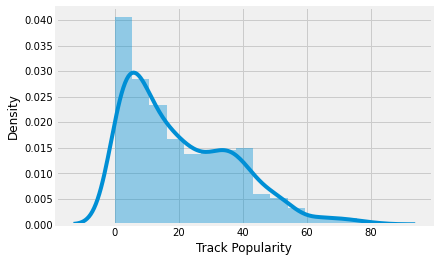

In [338]:
sns.distplot(df1['Track Popularity'])

In [339]:
df1[df1['Track Popularity']>=43].count()

Track Popularity     107
Release Dates        107
Artist Popularity    107
danceability         107
energy               107
loudness             107
speechiness          107
acousticness         107
instrumentalness     107
liveness             107
valence              107
tempo                107
date                 107
year                 107
key 1                107
key 2                107
key 3                107
key 4                107
key 5                107
key 6                107
key 7                107
key 8                107
key 9                107
key 10               107
key 11               107
mode 1               107
dtype: int64

In [340]:
df1[df1['Track Popularity']<=6].count()

Track Popularity     236
Release Dates        236
Artist Popularity    236
danceability         236
energy               236
loudness             236
speechiness          236
acousticness         236
instrumentalness     236
liveness             236
valence              236
tempo                236
date                 236
year                 236
key 1                236
key 2                236
key 3                236
key 4                236
key 5                236
key 6                236
key 7                236
key 8                236
key 9                236
key 10               236
key 11               236
mode 1               236
dtype: int64

In [341]:
#creating a target variable based on percentiles. let's pick 90 (43) and 25 (6) for now, I think I will need to raise 25 to 50 
# and later learn how to deal with imbalanced classes
df1['target']=0
for i in range(0,len(df1)):
    if df1['Track Popularity'].iloc[i]>=43:
        df1['target'].iloc[i]=1
    elif df1['Track Popularity'].iloc[i]<=6:
        df1['target'].iloc[i]=0
    else:
        df1['target'].iloc[i]=2

In [342]:
#drop middle class
df2=df1[df1['target']!=2]

In [343]:
df1.columns

Index(['Track Popularity', 'Release Dates', 'Artist Popularity',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'date', 'year',
       'key 1', 'key 2', 'key 3', 'key 4', 'key 5', 'key 6', 'key 7', 'key 8',
       'key 9', 'key 10', 'key 11', 'mode 1', 'target'],
      dtype='object')

<AxesSubplot:xlabel='target', ylabel='count'>

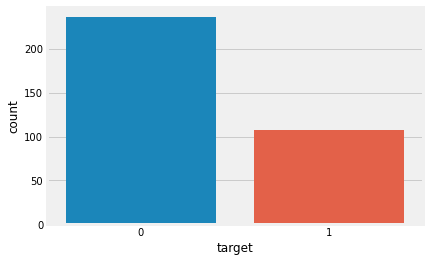

In [344]:
sns.countplot(data=df2, x='target')

In [345]:
df2.columns

Index(['Track Popularity', 'Release Dates', 'Artist Popularity',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'date', 'year',
       'key 1', 'key 2', 'key 3', 'key 4', 'key 5', 'key 6', 'key 7', 'key 8',
       'key 9', 'key 10', 'key 11', 'mode 1', 'target'],
      dtype='object')

In [346]:
df2[['danceability','energy','loudness',
            'speechiness','acousticness','instrumentalness',
                'liveness','valence','tempo','date','year']]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,date,year
1,0.831,0.6900,-7.339,0.0280,0.10600,0.002260,0.0973,0.7010,120.143,2021-11-05,2021
2,0.504,0.5090,-5.803,0.0304,0.70000,0.000012,0.1050,0.3770,183.962,2020-10-08,2020
5,0.778,0.1450,-11.950,0.0503,0.89200,0.000004,0.1260,0.2400,109.071,2019-04-19,2019
8,0.653,0.8770,-5.820,0.0275,0.01020,0.000010,0.3200,0.6200,109.985,2021-06-04,2021
12,0.493,0.6310,-7.883,0.0319,0.14800,0.000004,0.1380,0.3560,108.404,2022-02-04,2022
...,...,...,...,...,...,...,...,...,...,...,...
1081,0.664,0.6640,-7.132,0.0498,0.28400,0.000244,0.0627,0.6740,74.931,2020-07-30,2020
1086,0.843,0.0721,-17.779,0.2040,0.85900,0.017200,0.1020,0.0638,118.131,2021-08-25,2021
1090,0.430,0.7470,-6.370,0.0314,0.00001,0.946000,0.0882,0.5350,77.450,2019-12-13,2019
1093,0.520,0.7160,-10.359,0.0493,0.01070,0.073600,0.0899,0.3990,111.983,2020-01-23,2020


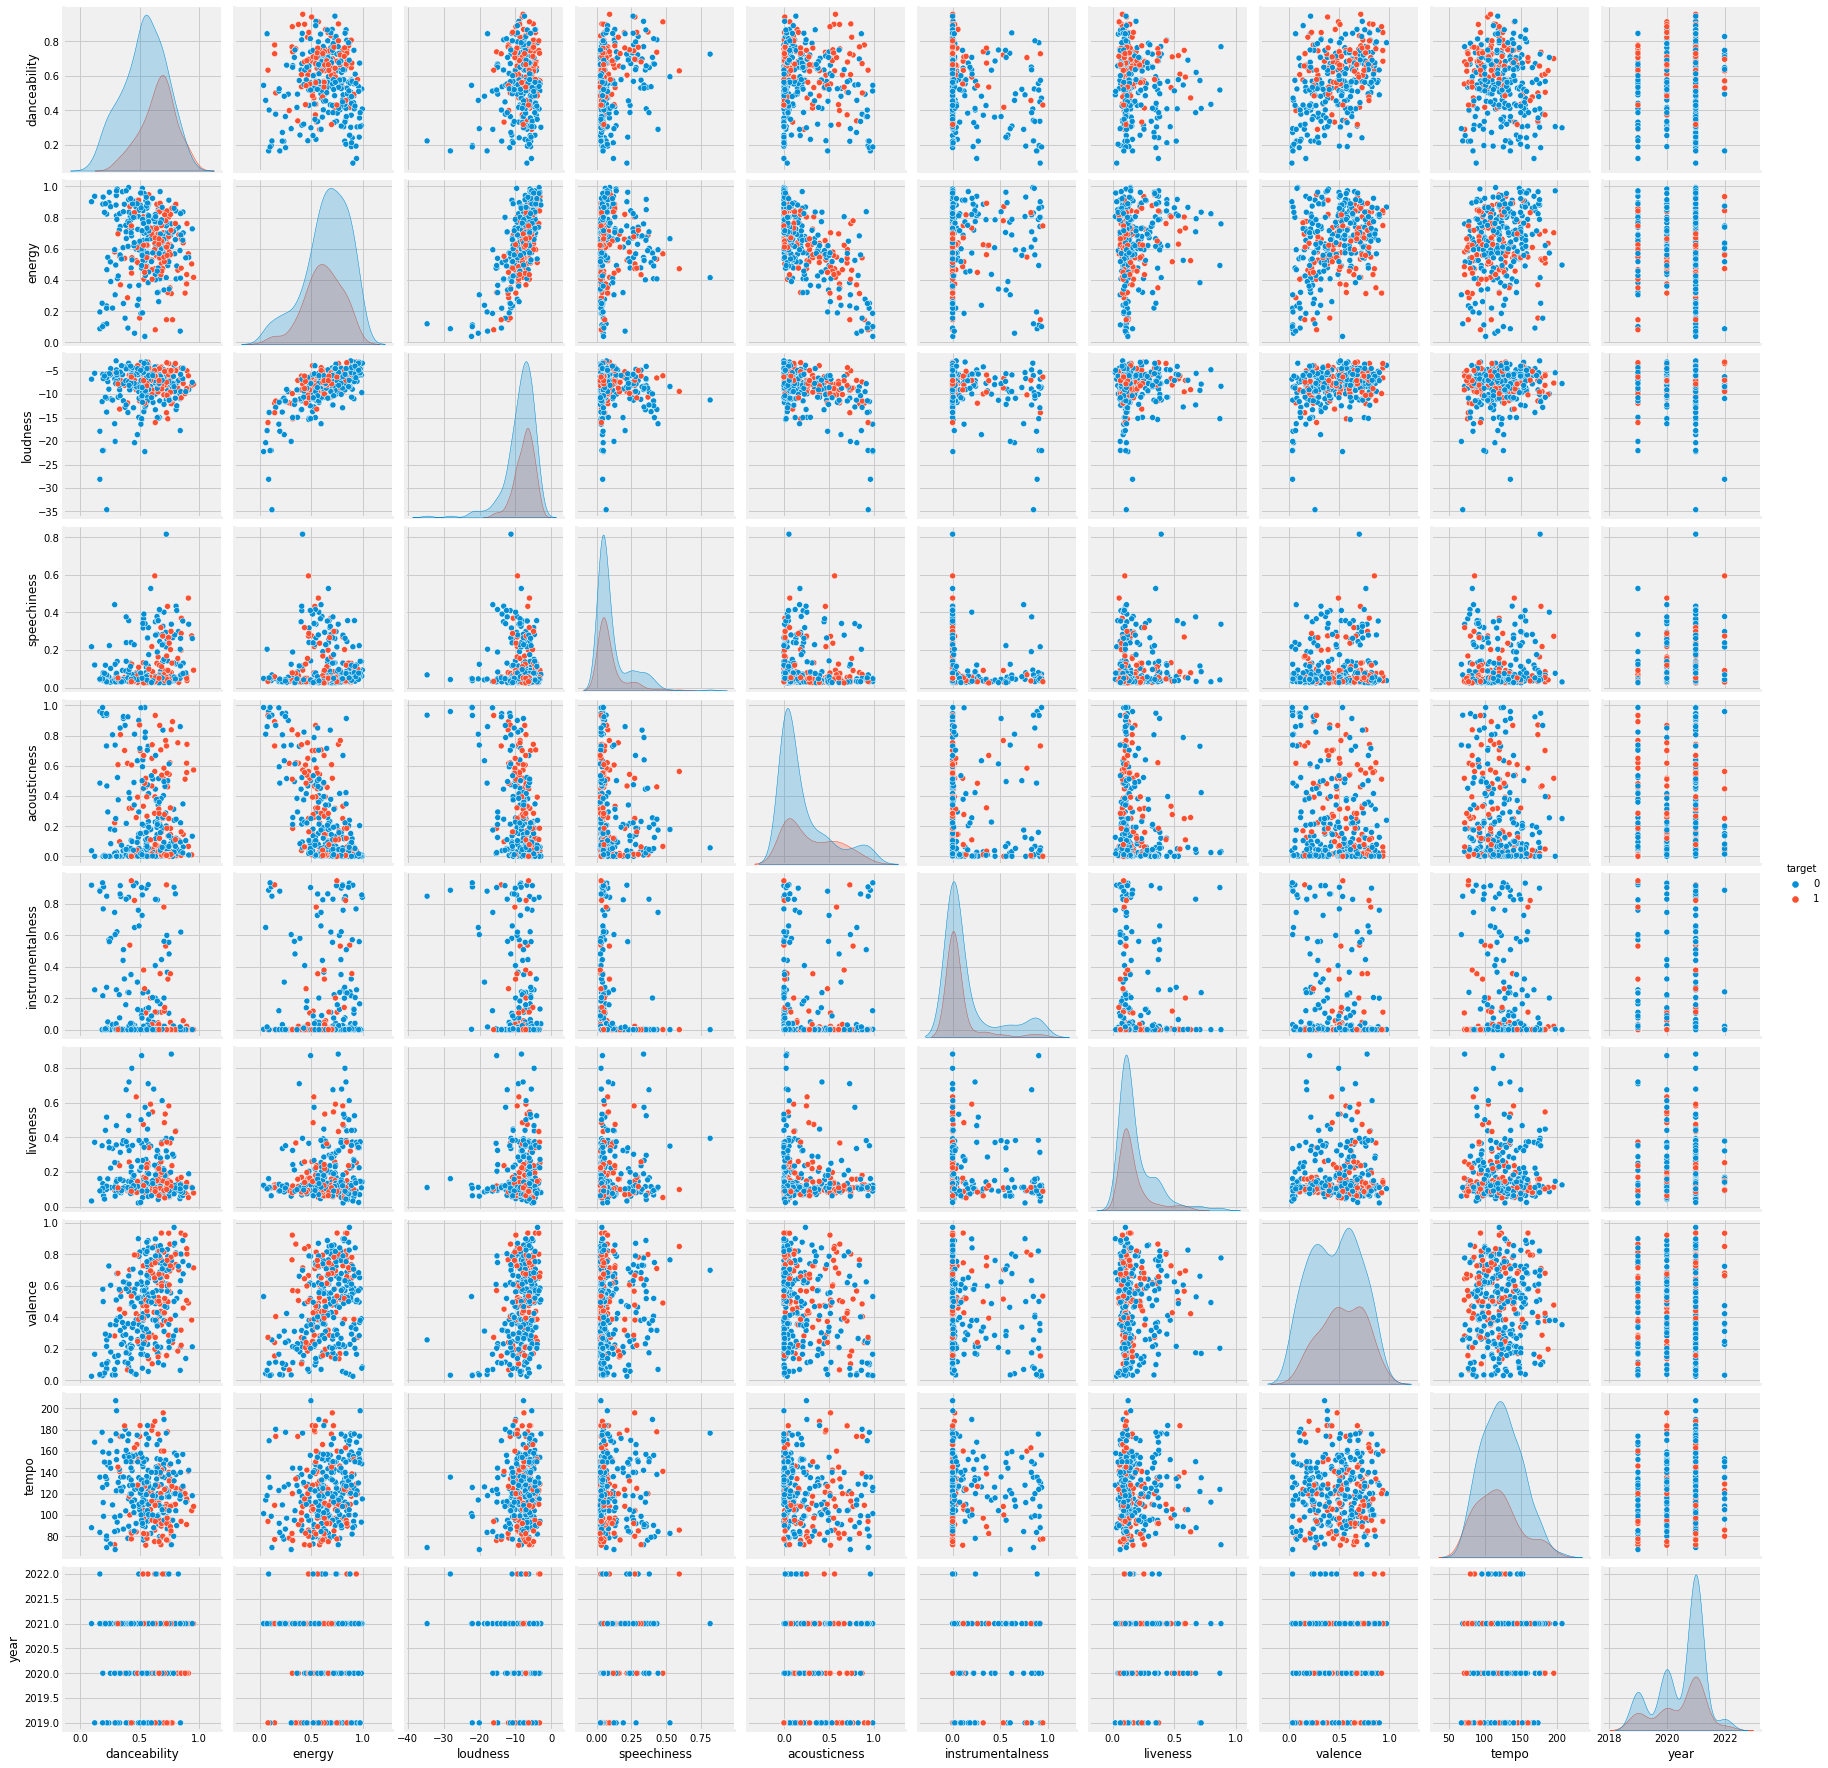

In [463]:
sns.pairplot(data=df2[['danceability','energy','loudness',
            'speechiness','acousticness','instrumentalness',
                'liveness','valence','tempo','date','year','target']],hue='target')

In [430]:
corr_df=df2[['danceability','energy','loudness',
            'speechiness','acousticness','instrumentalness',
                'liveness','valence','tempo']].corr()

<AxesSubplot:>

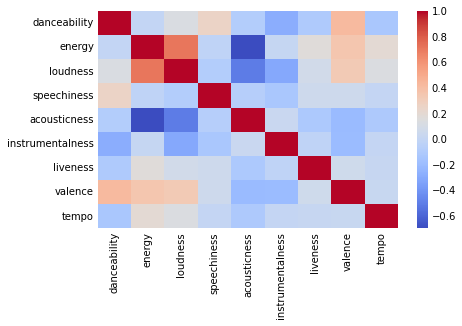

In [433]:
sns.heatmap(corr_df,cmap='coolwarm')

<AxesSubplot:xlabel='mode 1', ylabel='target'>

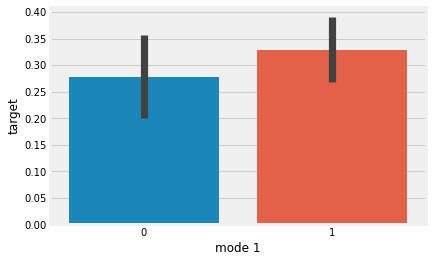

In [445]:
sns.barplot(x='mode 1',y='target',data=df2)

In [492]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Track Popularity','target','Release Dates','year','date','Artist Popularity'],axis=1), df2['target'], \
                                                            test_size=0.2, random_state=42)
#stratify=df2['target']

In [493]:
num_cols

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [494]:
#scaling
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
num_cols=X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c,np.floating))]
X_train_scaled=X_train
X_test_scaled=X_test
X_train_scaled[num_cols] = std_scale.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = std_scale.fit_transform(X_test_scaled[num_cols])

In [495]:
def print_scores(y_pred,y_test):
    print("accuracy score: {:6.4f}".format(accuracy_score(y_pred, y_test)))
    print("precision score: {:6.4f}".format(precision_score(y_pred, y_test)))
    print("recall score: {:6.4f}".format(recall_score(y_pred, y_test)))
    print("f1 score: {:6.4f}".format(f1_score(y_pred, y_test)))

In [496]:
#baseline
X_train_scaled

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key 1,...,key 3,key 4,key 5,key 6,key 7,key 8,key 9,key 10,key 11,mode 1
285,-0.975581,0.661060,0.327989,-0.595591,-0.840699,0.440540,-0.562574,-1.102413,-1.542507,0,...,0,1,0,0,0,0,0,0,0,0
31,-0.011334,1.199590,1.295307,-0.545964,-0.830536,-0.480469,1.280753,0.688798,0.491815,0,...,0,0,1,0,0,0,0,0,0,0
365,0.731247,-0.002487,0.561865,-0.315497,-0.558527,-0.396161,1.407345,-0.701148,0.494315,0,...,0,0,0,0,0,0,0,0,0,1
1057,-1.058706,0.343712,-1.114057,2.276838,-0.681334,2.742246,3.489089,-1.263746,1.029508,0,...,0,0,0,0,1,0,0,0,0,1
962,-0.310583,-0.382343,-0.078363,-0.399609,0.923616,2.341780,-0.477476,-0.589456,1.178528,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,-0.787165,-0.454468,0.183143,-0.592226,0.284883,-0.470111,-0.708859,-0.593593,1.028294,0,...,0,0,0,0,0,0,0,0,0,1
175,-0.011334,0.622593,0.400552,-0.419796,-0.247983,-0.476643,-0.519673,-1.420942,0.099999,0,...,0,0,0,0,0,0,0,0,1,1
259,0.387665,0.266779,0.135419,1.494596,-0.336206,-0.480708,-0.688463,-0.204739,1.602912,0,...,0,1,0,0,0,0,0,0,0,0
804,0.847622,0.988025,1.398012,-0.441665,-0.187992,-0.480920,1.365148,0.734303,-1.041774,0,...,0,0,0,1,0,0,0,0,0,1


In [498]:
#estimating baseline knn
knn = KNeighborsClassifier(10)
knn.fit(X_train_scaled, y_train)
y_knn=knn.predict(X_test_scaled)
print_scores(y_knn,y_test)


accuracy score: 0.7246
precision score: 0.1818
recall score: 0.8000
f1 score: 0.2963


In [499]:
knn_i = KNeighborsClassifier()
k_range=list(range(1,30))
param_grid_knn=dict(n_neighbors=k_range)
grid_knn=GridSearchCV(knn_i,param_grid_knn,cv=10,scoring='f1',verbose=1)
grid_knn.fit(X_train_scaled,y_train)


Fitting 10 folds for each of 29 candidates, totalling 290 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             scoring='f1', verbose=1)

In [552]:
grid_knn.best_params_

{'n_neighbors': 5}

In [500]:
y_grid_knn=grid_knn.predict(X_test_scaled)
print_scores(y_grid_knn,y_test)

accuracy score: 0.6812
precision score: 0.3182
recall score: 0.5000
f1 score: 0.3889


In [563]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_scaled, y_train)
y_knn_5=knn_5.predict(X_test_scaled)
print_scores(y_knn_5,y_test)

accuracy score: 0.6812
precision score: 0.3182
recall score: 0.5000
f1 score: 0.3889


In [505]:
logit_i=LogisticRegression(penalty='l2',solver='liblinear')
param_grid_logit={'C':[0.001,0.01,0.1,1,10,100,1000]}
grid_logit=GridSearchCV(logit_i,param_grid_logit,scoring='f1',verbose=1)
grid_logit.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1', verbose=1)

In [506]:
y_grid_logit=grid_logit.predict(X_test)
print_scores(y_grid_logit,y_test)

accuracy score: 0.7101
precision score: 0.3636
recall score: 0.5714
f1 score: 0.4444


In [564]:
logit=LogisticRegression(C=10)
logit.fit(X_train_scaled,y_train)
y_logit=logit.predict(X_test_scaled)
print_scores(y_logit,y_test)

accuracy score: 0.7101
precision score: 0.3636
recall score: 0.5714
f1 score: 0.4444


In [507]:
#random forest
rf=RandomForestClassifier(random_state=42)
#rf.fit(X_train,y_train)
#y_rf=rf.predict(X_test_scaled)

In [508]:
params_rf={'max_depth':[1,2,3,4,5,6,7,8],'min_samples_leaf':[1,5,7,10,15,20],'n_estimators':[5,10,20,30,40,50,100,200]}

In [509]:
grid_rf=GridSearchCV(estimator=rf,param_grid=params_rf,verbose=1,scoring='f1')

In [510]:
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 7, 10, 15, 20],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200]},
             scoring='f1', verbose=1)

In [364]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=5, n_estimators=5,
                       random_state=42)

In [512]:
#prediction on training data
y_rf_grid_train=grid_rf.predict(X_train)
print_scores(y_rf_grid_train,y_train)

accuracy score: 0.8358
precision score: 0.5882
recall score: 0.8333
f1 score: 0.6897


In [514]:
y_rf_grid=grid_rf.predict(X_test)
print_scores(y_rf_grid,y_test)

accuracy score: 0.6812
precision score: 0.2273
recall score: 0.5000
f1 score: 0.3125


In [515]:
print(confusion_matrix(y_knn,y_test))
print(confusion_matrix(y_logit,y_test))
print(confusion_matrix(y_rf_grid,y_test))

[[46 18]
 [ 1  4]]
[[41 14]
 [ 6  8]]
[[42 17]
 [ 5  5]]


In [557]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr1, tpr1,thresholds1 = roc_curve(y_test, grid_knn.predict_proba(X_test_scaled)[:,1]) 
fpr2, tpr2, thresholds2 = roc_curve(y_test, logit.predict_proba(X_test_scaled)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, grid_rf_os.predict_proba(X_test_scaled)[:,1])
fpr4,tpr4, thresholds4 = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpr5,tpr5,thresholds5 = roc_curve(y_test,gbm_smote.predict_proba(X_test)[:,1])

ROC AUC KNN score =  0.6237911025145068
ROC AUC Logistic score =  0.758220502901354
ROC AUC Random Forest OS =  0.6808510638297872
ROC AUC XGBOOST =  0.6692456479690522
ROC AUC XGBOOST SMOTE =  0.6914893617021276
F1 KNN score =  0.3888888888888889
F1 Logistic score =  0.4444444444444444
F1 Random Forest OS =  0.3888888888888889
F1 XGBOOST =  0.41025641025641024
F1 XGBOOST SMOTE =  0.5925925925925926


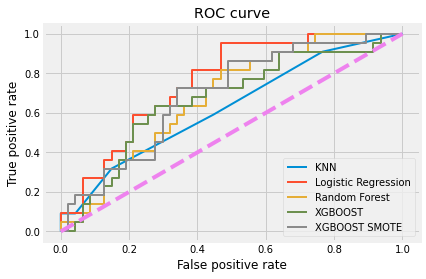

In [573]:
plt.plot(fpr1, tpr1,lw=2)
plt.plot(fpr2, tpr2,lw=2)
plt.plot(fpr3, tpr3,lw=2)
plt.plot(fpr4, tpr4,lw=2)
plt.plot(fpr5, tpr5,lw=2)

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC KNN score = ", roc_auc_score(y_test, grid_knn.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC Logistic score = ", roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC Random Forest OS = ", roc_auc_score(y_test, grid_rf_os.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC XGBOOST = ", roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))
print("ROC AUC XGBOOST SMOTE = ", roc_auc_score(y_test, gbm_smote.predict_proba(X_test)[:,1]))
print("F1 KNN score = ", f1_score (y_test, grid_knn.predict(X_test_scaled)))
print("F1 Logistic score = ", f1_score(y_test, logit.predict(X_test_scaled)))
print("F1 Random Forest OS = ", f1_score(y_test, grid_rf_os.predict(X_test_scaled)))
print("F1 XGBOOST = ", f1_score(y_test, gbm.predict(X_test)))
print("F1 XGBOOST SMOTE = ", f1_score(y_test, y_gbm_smote))
plt.legend(['KNN','Logistic Regression','Random Forest','XGBOOST','XGBOOST SMOTE'])

In [525]:
#oversampling
import imblearn.over_sampling

# setup for the ratio argument 
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 2, 0 : n_neg} 

# randomly oversample positive samples: create 2x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_os, y_tr_os = ROS.fit_resample(X_train_scaled, y_train)

lr= LogisticRegression(solver='liblinear') 
lr.fit(X_train_scaled, y_train)

print('Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr.predict(X_test_scaled)), roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_os, y_tr_os)

print('Logistic Regression on Oversampled Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_os.predict(X_test_scaled)), roc_auc_score(y_test, lr_os.predict_proba(X_test_scaled)[:,1])))


Logistic Regression; Test F1: 0.444, Test AUC: 0.758
Logistic Regression on Oversampled Data; Test F1: 0.500, Test AUC: 0.745


In [526]:
#smote
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_smote.predict(X_test_scaled)), roc_auc_score(y_test, lr_smote.predict_proba(X_test_scaled)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.583, Test AUC: 0.777


In [527]:
#oversampling with random forest
grid_rf_os=GridSearchCV(estimator=rf,param_grid=params_rf,verbose=1,scoring='f1')

In [528]:
grid_rf_os.fit(X_tr_os,y_tr_os)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 7, 10, 15, 20],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200]},
             scoring='f1', verbose=1)

In [529]:
print('Random Forest on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, grid_rf_os.predict(X_test_scaled)), roc_auc_score(y_test, grid_rf_os.predict_proba(X_test_scaled)[:,1])))

Random Forest on Oversampled Train Data; Test F1: 0.389, Test AUC: 0.681


In [560]:
grid_rf_smote=GridSearchCV(estimator=rf,param_grid=params_rf,verbose=1,scoring='f1')
grid_rf_smote.fit(X_tr_smote,y_tr_smote)


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 7, 10, 15, 20],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200]},
             scoring='f1', verbose=1)

In [532]:
#random forest performed slightly better with oversampled data
y_grid_rf_smote=grid_rf_smote.predict(X_test)
print_scores(y_grid_rf_smote,y_test)

accuracy score: 0.6667
precision score: 0.3182
recall score: 0.4667
f1 score: 0.3784


In [537]:
#try XGBoost
#split training data into train and validation set
#XGBoost is overfitted.
X_train_xg, X_val, y_train_xg, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=101)
gbm = xgb.XGBClassifier( 
                        n_estimators=300,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        #alpha=1
                        subsample=.8,
                        min_child_weight=5,
                        colsample_bytree=.9
                       )

eval_set=[(X_train_xg,y_train_xg),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train_xg, y_train_xg, 
                    eval_set=eval_set,
                    eval_metric='aucpr', 
                    early_stopping_rounds=100,
                    verbose=False
                   )

y_gbm=gbm.predict(X_test)
y_gbm2=gbm.predict(X_train_xg)

print_scores(y_gbm,y_test)
print_scores(y_gbm2,y_train_xg)

accuracy score: 0.6667
precision score: 0.3636
recall score: 0.4706
f1 score: 0.4103
accuracy score: 0.9863
precision score: 0.9545
recall score: 1.0000
f1 score: 0.9767


In [570]:
#XGBoost with Oversampled data
#The problem with overfitting was significantly reduced with oversampled data.
X_train_xg_os, X_val_os, y_train_xg_os, y_val_os = train_test_split(X_tr_os, y_tr_os, test_size=0.2, random_state=101)
    
gbm_os = xgb.XGBClassifier( 
                        n_estimators=3000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.3, 
                        #alpha=1
                        subsample=.2,# 0.2 leads to 0.65 vs 0.7 Test/Train F1 score
                        min_child_weight=5,
                        colsample_bytree=0.9 #0.9 leads to 0.65 vs 0.7 Test/Train F1 score
                       )

eval_set_os=[(X_train_xg_os,y_train_xg_os),(X_val_os,y_val_os)]
fit_model_os = gbm_os.fit( 
                    X_train_xg_os, y_train_xg_os, 
                    eval_set=eval_set_os,
                    eval_metric='aucpr',#aucpr 
                    early_stopping_rounds=100,
                    verbose=False
                   )

y_gbm_os=gbm_os.predict(X_test)
y_gbm2_os=gbm_os.predict(X_train_xg_os)

print_scores(y_gbm_os,y_test)
print_scores(y_gbm2_os,y_train_xg_os)


accuracy score: 0.6522
precision score: 0.5455
recall score: 0.4615
f1 score: 0.5000
accuracy score: 0.7979
precision score: 0.7721
recall score: 0.7955
f1 score: 0.7836


In [571]:
#XGBoost with Smote data
#Performed slightly better than with Oversampled data
X_train_xg_smote, X_val_smote, y_train_xg_smote, y_val_smote = train_test_split(X_tr_smote, y_tr_smote, test_size=0.2, random_state=101)
    
gbm_smote = xgb.XGBClassifier( 
                        n_estimators=3000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=.3, 
                        #alpha=1
                        subsample=.2,# 0.2 leads to 0.65 vs 0.7 Test/Train F1 score
                        min_child_weight=5,
                        colsample_bytree=0.9 #0.9 leads to 0.65 vs 0.7 Test/Train F1 score
                       )

eval_set_smote=[(X_train_xg_smote,y_train_xg_smote),(X_val_smote,y_val_smote)]
fit_model_smote = gbm_smote.fit( 
                    X_train_xg_smote, y_train_xg_smote, 
                    eval_set=eval_set_smote,
                    eval_metric='aucpr',#aucpr 
                    early_stopping_rounds=100,
                    verbose=False
                   )

y_gbm_smote=gbm_smote.predict(X_test)
y_gbm2_smote=gbm_smote.predict(X_train_xg_smote)

print_scores(y_gbm_smote,y_test)
print_scores(y_gbm2_smote,y_train_xg_smote)


accuracy score: 0.6812
precision score: 0.7273
recall score: 0.5000
f1 score: 0.5926
accuracy score: 0.7352
precision score: 0.7647
recall score: 0.7027
f1 score: 0.7324


In [419]:
#Exploring feature importance
#Use shapley values with linear regression
import shap
shap.initjs()
explainer = shap.LinearExplainer(logit, X_train_scaled,feature_pertubation="interventional")



In [420]:
shap_values = explainer.shap_values(X_test_scaled)


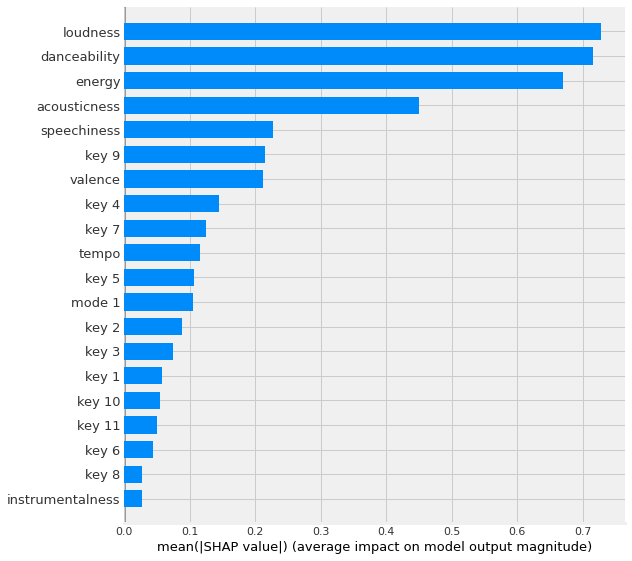

In [422]:
shap.summary_plot(shap_values,X_test_scaled,plot_type='bar')

Text(0.5, 1, 'Feature Importance')

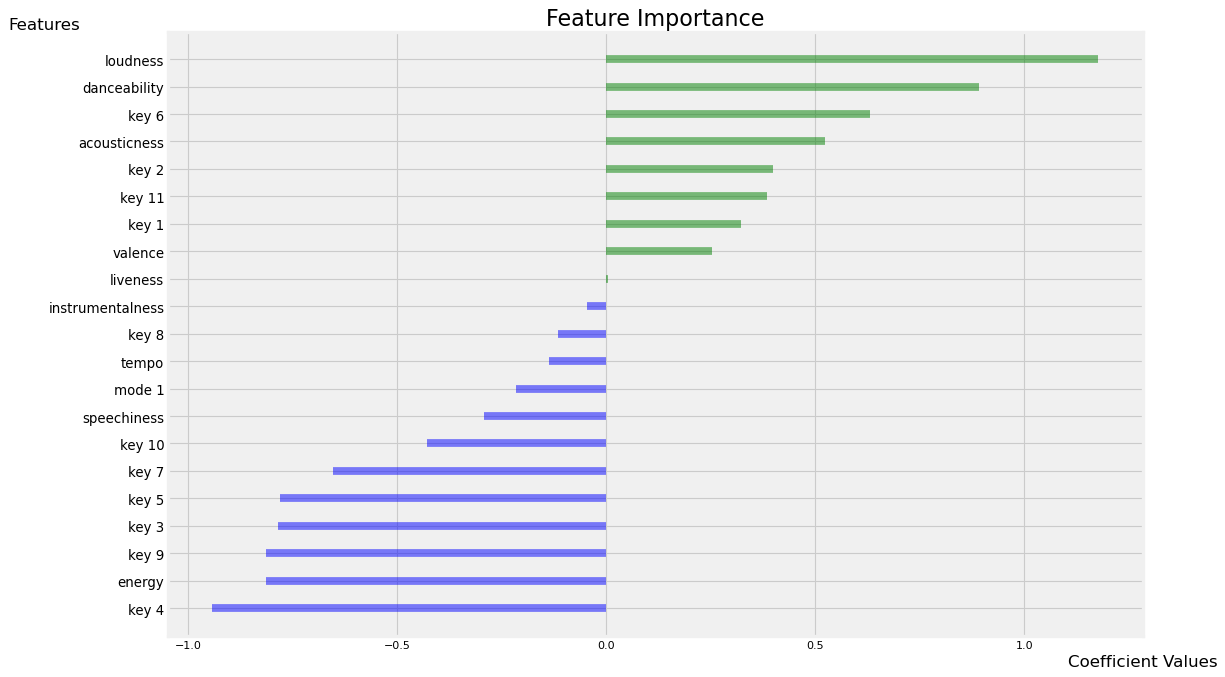

In [545]:
#use importance coefficients with logistic regression
logit_feature_df = pd.DataFrame.from_dict({'Features': X_train_scaled.columns, 
                                        'Coefs': logit.coef_[0]})

logit_feature_df['Colors'] = logit_feature_df['Coefs'].apply(lambda coef: 'blue' 
                                                          if coef < 0 else 'green')

logit_feature_df = logit_feature_df.sort_values('Coefs', ascending = True).reset_index(drop = True)

plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y = logit_feature_df.index, xmin = 0, xmax = logit_feature_df['Coefs'], 
           color=  logit_feature_df['Colors'], alpha=0.5, linewidth=7)

plt.xlabel(xlabel = 'Coefficient Values', size = 15, x = 1)
plt.ylabel(ylabel = 'Features', size = 15, rotation = 0, y = 1)

plt.yticks(logit_feature_df.index, logit_feature_df['Features'], fontsize=12)
plt.title('Feature Importance', fontsize=20,y=1)


In [384]:
#Supplemental Analysis
#naive bayes Bernoulli model
df3=df2.drop(['Track Popularity','Release Dates','year','date','Artist Popularity'],axis=1)
                                                           

In [385]:
df3.describe(percentiles=[.10,.15,.20,.25,.5,.75,.8,.85,.9])

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key 1,...,key 4,key 5,key 6,key 7,key 8,key 9,key 10,key 11,mode 1,target
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,...,343.00000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,0.575360,0.637594,-8.317452,0.104739,0.236422,0.128936,0.180983,0.481429,121.767370,0.090379,...,0.06414,0.069971,0.069971,0.093294,0.081633,0.122449,0.072886,0.090379,0.664723,0.311953
std,0.178609,0.207067,3.759669,0.115384,0.280564,0.262109,0.146248,0.238126,28.759174,0.287143,...,0.24536,0.255471,0.255471,0.291270,0.274204,0.328283,0.260330,0.287143,0.472777,0.463968
min,0.093400,0.038200,-34.628000,0.024200,0.000003,0.000000,0.020900,0.026300,67.489000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.313800,0.362000,-12.168600,0.029840,0.001254,0.000000,0.072720,0.157200,84.472800,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15%,0.378800,0.434300,-11.111500,0.031300,0.004989,0.000000,0.083660,0.208300,91.143800,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20%,0.422200,0.480800,-10.532800,0.033240,0.009830,0.000000,0.090840,0.240400,95.020800,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.456500,0.526000,-9.686000,0.035700,0.014350,0.000001,0.096600,0.282000,99.130500,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.576000,0.659000,-7.587000,0.050300,0.104000,0.000401,0.118000,0.500000,120.031000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.705500,0.802000,-5.932500,0.119000,0.395000,0.080850,0.220500,0.677000,140.047000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [516]:
#hard coded thresholds
thresholds=[dance_th,energy_th,loud_th,speech_th,ac_th,inst_th,live_th,val_th,tempo_th]
dance_th=0.57
energy_th=0.64
loud_th=-8.32
speech_th=0.1
ac_th=0.24
inst_th=0.13
live_th=0.18
val_th=0.48
tempo_th=121.77

In [387]:
cols=list(df3.columns[df3.dtypes.apply(lambda c: np.issubdtype(c,np.floating))])
cols

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [389]:
def convert(feat,threshold,df3):
    for j in range(0,len(df3)):
        if df3[feat].iloc[j]>=threshold:
            df3[feat].iloc[j]=1
        else:
            df3[feat].iloc[j]=0
    
    

In [390]:
for i in range(0,len(cols)):
    convert(cols[i],thresholds[i],df3)

In [391]:
X_train_be, X_test_be, y_train_be, y_test_be = train_test_split(df3.drop(['target'],axis=1), df3['target'], \
                                                            test_size=0.2, random_state=42)

In [517]:
nb_be = BernoulliNB()
nb_be.fit(X_train_be, y_train_be)
y_pred_be=nb_be.predict(X_test)
print_scores(y_pred_be,y_test)

accuracy score: 0.7101
precision score: 0.4091
recall score: 0.5625
f1 score: 0.4737


In [519]:
print_scores(nb_be.predict(X_train_be),y_train_be)

accuracy score: 0.7591
precision score: 0.4471
recall score: 0.6667
f1 score: 0.5352


In [229]:
confusion_matrix(y_test_be,y_pred_be)

array([[40,  7],
       [13,  9]])